In [1]:
# Here we will import torch for core tensor library and .nn for the NN library.
#The transformers are for preprocessing ie we willl be converting to tensor and then normalizing using this library
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#The confusing matrix and classification report is basically for us to construct precision recall and f1 score and prepare a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
# I am doing this so that if GPU is available i will be initializing CUDA or ill be using CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# We basically do this to load the data and split the dataset
# Data transformation pipeline
transform = transforms.Compose([
    #Here we will be transforming image pixels too float tensors makign sure that our shape becomes 3D
    transforms.ToTensor(),
    #We are normalizing here because we want to improve the gradiant stability
    transforms.Normalize((0.5,), (0.5,))
])
#Here i will be loading the dataset of many images and putting them in my test and train dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

#As we already know we wll be using 80% of the data for the training and 20% for the testing
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
#Now we are loading the data into packets of 64 images and we will be randomizing them
#Reason: SDG here appproximates full gradiants using batches gradiants
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
#Now we are declaring a function which is in form of f1(f2(...))) and they are multiple layers of functions as
class MLP(nn.Module):
    #Now we take input dimensions to be 784 and we have hidden sizes which controls the size and width of the model
    def __init__(self, input_size=784, hidden_sizes=[256],num_classes=10, dropout=0.0, batchnorm=False):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_size, h))
            if batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_size = h
        #Now here we are supposed to show it in form of wx + b where w = hx previous size
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
#We can also try stabilize the training set by doing batch normalization by normalizing per batch
    # Then we use ReLU which is reclinear linear unit which is a non linear function which has similar properties as such of the linear ones. It is some osrt of a 2 piece function and resembles a lot of proeprties of a linear transformation
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

In [4]:
#This is the main training loop and here we are trying to minimize the function data using scholastic gradient descent
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=20):
    #Now we initialize the losses and accuracy for epoch
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    #Now we will send each epoch in the entire loop so that we are sending many batches per epoch(upto 750 ig considering 48000 images to be in our training data set and 64 per batch)
    for epoch in range(epochs):
        #We now train the model so that dropout is enabled and batch norm uses batch statistics instead of running averages every time
        model.train()
        #Now we compute mean training loss and training accuracy
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            #if we dont use zero grad we will essentially have gradiants being added across the batch and updates become incorrect. THis is happeneign because pytorch accumulates gradients by default
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                #Here we basically compute f(x;theta)
                outputs = model(images)
                #We now compute the cross entropic loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                #we now compute the predictions
                _, predicted = outputs.max(1)
                #Now compute the correct predictions
                val_correct += predicted.eq(labels).sum().item()
                #count total samples and after each epoch we must hve near 4800 images as it was our training set images
                val_total += labels.size(0)
        #We now caluculate the loss and accuracy per batch
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_accs[-1]:.4f} | "
              f"Val Acc: {val_accs[-1]:.4f}")
    #now we get back our list of length which indicates number of epoches
    return train_losses, val_losses, train_accs, val_accs
# If we have to conclude what we are doing in this we are mathematically caluculating the approximations for a mathematical function and in mini batches we are computing risks which is trained and we estimate generalization for validation and update the parameters
#We use len(train losses) because running loss is acumulated batch average and the loss keeps growing with number of batches without division

In [5]:
model_baseline = MLP(hidden_sizes=[128]).to(device)
# here we are going to be using scholastic gradiant descent with momentum so we reduce oscillations and speed up convergence and accumulate gradiant direction
optimizer = optim.SGD(model_baseline.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_model(model_baseline, train_loader, val_loader, optimizer, criterion)

Epoch 1/20 | Train Acc: 0.8005 | Val Acc: 0.8375
Epoch 2/20 | Train Acc: 0.8529 | Val Acc: 0.8618
Epoch 3/20 | Train Acc: 0.8673 | Val Acc: 0.8542
Epoch 4/20 | Train Acc: 0.8751 | Val Acc: 0.8650
Epoch 5/20 | Train Acc: 0.8821 | Val Acc: 0.8708
Epoch 6/20 | Train Acc: 0.8878 | Val Acc: 0.8786
Epoch 7/20 | Train Acc: 0.8924 | Val Acc: 0.8771
Epoch 8/20 | Train Acc: 0.8960 | Val Acc: 0.8754
Epoch 9/20 | Train Acc: 0.8992 | Val Acc: 0.8769
Epoch 10/20 | Train Acc: 0.9028 | Val Acc: 0.8818
Epoch 11/20 | Train Acc: 0.9059 | Val Acc: 0.8847
Epoch 12/20 | Train Acc: 0.9096 | Val Acc: 0.8869
Epoch 13/20 | Train Acc: 0.9130 | Val Acc: 0.8822
Epoch 14/20 | Train Acc: 0.9135 | Val Acc: 0.8782
Epoch 15/20 | Train Acc: 0.9160 | Val Acc: 0.8754
Epoch 16/20 | Train Acc: 0.9187 | Val Acc: 0.8915
Epoch 17/20 | Train Acc: 0.9231 | Val Acc: 0.8845
Epoch 18/20 | Train Acc: 0.9225 | Val Acc: 0.8799
Epoch 19/20 | Train Acc: 0.9270 | Val Acc: 0.8773
Epoch 20/20 | Train Acc: 0.9280 | Val Acc: 0.8888


([0.5541807268261909,
  0.40570656905571617,
  0.3668062521417936,
  0.34362078266342483,
  0.3218115053375562,
  0.3060682741800944,
  0.29287801232437294,
  0.2801616627573967,
  0.2711303764730692,
  0.2629803650180499,
  0.2547024706353744,
  0.24443712779382865,
  0.23452671098709107,
  0.2301055632730325,
  0.22564707464973133,
  0.21818022886912028,
  0.21004782336453598,
  0.20628848779201509,
  0.19742394166688124,
  0.1933637697895368],
 [0.44972356297868366,
  0.3891886715242203,
  0.39440223955093545,
  0.36278002197913667,
  0.3621781372881316,
  0.33207427845039267,
  0.3464767378061376,
  0.34007203689915066,
  0.3481964091671274,
  0.33102985166330284,
  0.32004943161093174,
  0.3193438159935969,
  0.3294637244036223,
  0.34297533836612043,
  0.36454411148232346,
  0.3132963638673437,
  0.3303030806970089,
  0.34840244455064867,
  0.35084446476019443,
  0.32578748317950584],
 [0.8004791666666666,
  0.852875,
  0.8672708333333333,
  0.8750833333333333,
  0.8820625,
  0.8

In [6]:
model_deep = MLP(hidden_sizes=[512, 256, 128]).to(device)
#here we will be using adam update and the bias is correctly applied
optimizer = optim.Adam(model_deep.parameters(), lr=0.001)
train_model(model_deep, train_loader, val_loader, optimizer, criterion)
# We need to remember that if the gneeralization gap is bigger than the baseline we are overfitting and indicates higher capacity
# Adam adapts learning rates per parameter so this is the reason why deep models train faster
# if we want to improve the accuracy of the training data we can just add more parameters which would mean high representation power

Epoch 1/20 | Train Acc: 0.8073 | Val Acc: 0.8394
Epoch 2/20 | Train Acc: 0.8580 | Val Acc: 0.8619
Epoch 3/20 | Train Acc: 0.8729 | Val Acc: 0.8627
Epoch 4/20 | Train Acc: 0.8803 | Val Acc: 0.8760
Epoch 5/20 | Train Acc: 0.8902 | Val Acc: 0.8795
Epoch 6/20 | Train Acc: 0.8961 | Val Acc: 0.8844
Epoch 7/20 | Train Acc: 0.9015 | Val Acc: 0.8840
Epoch 8/20 | Train Acc: 0.9065 | Val Acc: 0.8812
Epoch 9/20 | Train Acc: 0.9124 | Val Acc: 0.8847
Epoch 10/20 | Train Acc: 0.9161 | Val Acc: 0.8898
Epoch 11/20 | Train Acc: 0.9205 | Val Acc: 0.8839
Epoch 12/20 | Train Acc: 0.9225 | Val Acc: 0.8962
Epoch 13/20 | Train Acc: 0.9267 | Val Acc: 0.8916
Epoch 14/20 | Train Acc: 0.9314 | Val Acc: 0.8898
Epoch 15/20 | Train Acc: 0.9343 | Val Acc: 0.8906
Epoch 16/20 | Train Acc: 0.9372 | Val Acc: 0.8926
Epoch 17/20 | Train Acc: 0.9411 | Val Acc: 0.8906
Epoch 18/20 | Train Acc: 0.9441 | Val Acc: 0.8913
Epoch 19/20 | Train Acc: 0.9464 | Val Acc: 0.8954
Epoch 20/20 | Train Acc: 0.9491 | Val Acc: 0.8894


([0.5237264090776443,
  0.3853817463318507,
  0.34506571339567504,
  0.31879827560981117,
  0.29333247837424276,
  0.2776543650527795,
  0.26022817649443947,
  0.2467062444984913,
  0.23411951572199663,
  0.22163833190004031,
  0.2096017441401879,
  0.2028997033337752,
  0.1892692452718814,
  0.17916861790418626,
  0.1729465190495054,
  0.16217630150417486,
  0.1545301597143213,
  0.1466048346956571,
  0.14135341748595237,
  0.13556937563916047],
 [0.42619933497081414,
  0.388047115203548,
  0.3771810532408826,
  0.3375423140823841,
  0.3315026032480788,
  0.3229567619397285,
  0.33381310731489605,
  0.34416043013334274,
  0.3341673246406494,
  0.3194452793674266,
  0.34173337570292517,
  0.3298925195642291,
  0.33561396024170076,
  0.34244591802200103,
  0.34917185546711405,
  0.35886656975452885,
  0.37059565855467574,
  0.4016232835921518,
  0.37598634001977266,
  0.3921009002233598],
 [0.8072916666666666,
  0.858,
  0.8729375,
  0.8802916666666667,
  0.8901666666666667,
  0.8961041

In [7]:
#Now we create a regularized deep MLP
# for each hidden layer we have linear, batch norm, ReLU, and dropout
model_reg = MLP(hidden_sizes=[512, 256],dropout=0.5,batchnorm=True).to(device)
optimizer = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=1e-4)
#we are using adam with L2 regulation here
train_model(model_reg, train_loader, val_loader, optimizer, criterion)

Epoch 1/20 | Train Acc: 0.8019 | Val Acc: 0.8569
Epoch 2/20 | Train Acc: 0.8392 | Val Acc: 0.8652
Epoch 3/20 | Train Acc: 0.8503 | Val Acc: 0.8626
Epoch 4/20 | Train Acc: 0.8579 | Val Acc: 0.8752
Epoch 5/20 | Train Acc: 0.8611 | Val Acc: 0.8715
Epoch 6/20 | Train Acc: 0.8641 | Val Acc: 0.8760
Epoch 7/20 | Train Acc: 0.8684 | Val Acc: 0.8792
Epoch 8/20 | Train Acc: 0.8716 | Val Acc: 0.8818
Epoch 9/20 | Train Acc: 0.8734 | Val Acc: 0.8820
Epoch 10/20 | Train Acc: 0.8736 | Val Acc: 0.8823
Epoch 11/20 | Train Acc: 0.8767 | Val Acc: 0.8834
Epoch 12/20 | Train Acc: 0.8788 | Val Acc: 0.8878
Epoch 13/20 | Train Acc: 0.8779 | Val Acc: 0.8862
Epoch 14/20 | Train Acc: 0.8805 | Val Acc: 0.8904
Epoch 15/20 | Train Acc: 0.8797 | Val Acc: 0.8892
Epoch 16/20 | Train Acc: 0.8823 | Val Acc: 0.8871
Epoch 17/20 | Train Acc: 0.8846 | Val Acc: 0.8892
Epoch 18/20 | Train Acc: 0.8836 | Val Acc: 0.8858
Epoch 19/20 | Train Acc: 0.8864 | Val Acc: 0.8890
Epoch 20/20 | Train Acc: 0.8858 | Val Acc: 0.8877


([0.5610067915916442,
  0.44522044171889624,
  0.41597198084990183,
  0.39294063570102056,
  0.38087174652020134,
  0.3711796113848686,
  0.36023488410313925,
  0.35258006836970646,
  0.3480169755419095,
  0.34013330656290053,
  0.33793304002285,
  0.33077690478165944,
  0.33177776928742725,
  0.3248327377438545,
  0.32497223181525864,
  0.31985156081120175,
  0.31226396465301515,
  0.3151456364492575,
  0.3087198538382848,
  0.30950806151827176],
 [0.3996368796425931,
  0.3642099487813229,
  0.3803114097644674,
  0.34337117154388985,
  0.3426106583247793,
  0.3342904077565416,
  0.3339920767602768,
  0.31812005081867917,
  0.3243214745629341,
  0.3158027950991341,
  0.31805070921620154,
  0.30965395097402815,
  0.3042141177315027,
  0.30321972579398054,
  0.3016216509202693,
  0.30187927757171873,
  0.30408939711273986,
  0.30732744179190474,
  0.30121925774406877,
  0.30760322578568405],
 [0.8018958333333334,
  0.8392083333333333,
  0.8503333333333334,
  0.8578541666666667,
  0.86106

In [8]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.legend()
    plt.show()


In [9]:
def evaluate(model, loader):
    # We now evaluate the models and then list them in the correct all predicted labels and all true labels
    model.eval()
    all_preds = []
    all_labels = []
    # We will now disable Gradient computation because it saves memory and speeds up computation. It prevents autograd from storing computation graph
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            #CPU tensors are thn converted to numpy again
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds))
    # Here we will print all the metrics with average and support
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
# This function basically measures all the metrics required and show the confusion patterns

In [10]:
def show_misclassified(model, loader):
    model.eval()
    # we will store misclassified image tensor list, predicted class and true class
    images_list = []
    preds_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, predicted = outputs.max(1)
            for i in range(len(images)):
                if predicted[i] != labels[i]:
                    # We now store each image in the list
                    images_list.append(images[i])
                    preds_list.append(predicted[i].item())
                    labels_list.append(labels[i].item())
                if len(images_list) >= 10:
                    break
            if len(images_list) >= 10:
                break
    plt.figure(figsize=(10,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        # .squeeze() basically removes channel dimension
        plt.imshow(images_list[i].squeeze(), cmap='gray')
        plt.title(f"P:{preds_list[i]} T:{labels_list[i]}")
        plt.axis('off')
    plt.show()
# This one shows where the model fails and how we need to understand the class confusion
# we use cpu before numpy ccause numpy cant access GPU memory
# here we stop at 10 misclassified for visual clarity

Epoch 1/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 2/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 3/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 4/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 5/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 6/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 7/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 8/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 9/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 10/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 11/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 12/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 13/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 14/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 15/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 16/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 17/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 18/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 19/20 | Train Acc: 0.9350 | Val Acc: 0.8888
Epoch 20/20 | Train Acc: 0.9350 | Val Acc: 0.8888


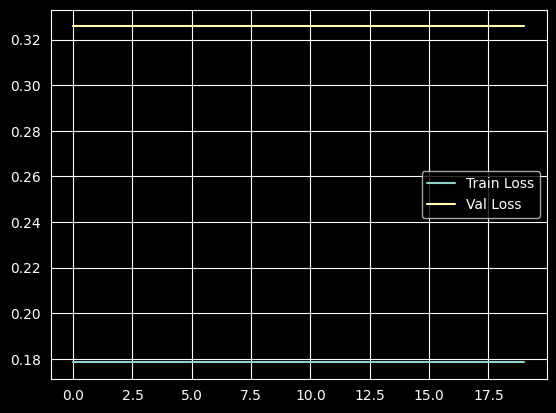

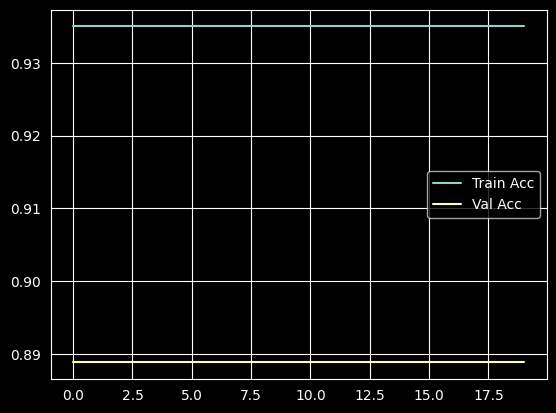

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.84      0.80      1000
           3       0.86      0.92      0.89      1000
           4       0.85      0.76      0.80      1000
           5       0.95      0.97      0.96      1000
           6       0.69      0.68      0.69      1000
           7       0.94      0.94      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



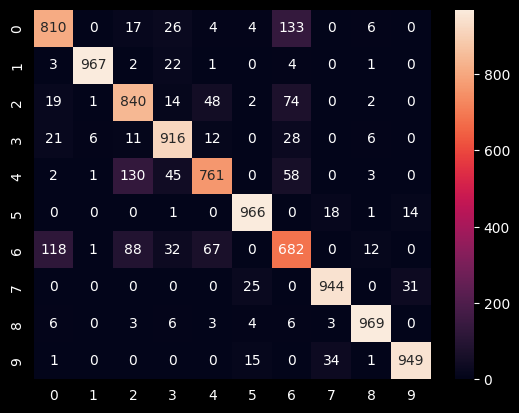

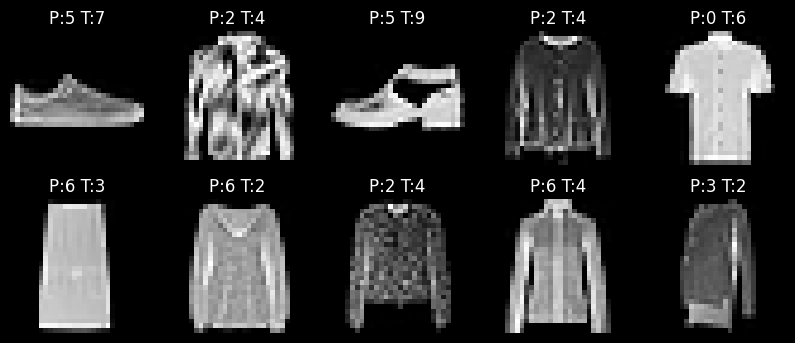

In [11]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model_baseline,
    train_loader,
    val_loader,
    optimizer,
    criterion
)

plot_curves(train_losses, val_losses, train_accs, val_accs)
evaluate(model_baseline, test_loader)
show_misclassified(model_baseline, test_loader)

Epoch 1/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 2/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 3/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 4/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 5/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 6/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 7/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 8/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 9/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 10/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 11/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 12/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 13/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 14/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 15/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 16/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 17/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 18/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 19/20 | Train Acc: 0.9564 | Val Acc: 0.8894
Epoch 20/20 | Train Acc: 0.9564 | Val Acc: 0.8894


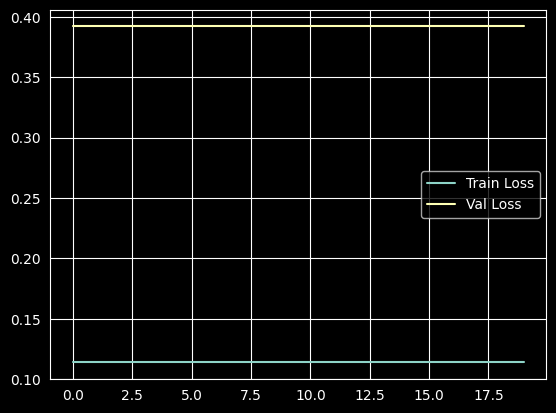

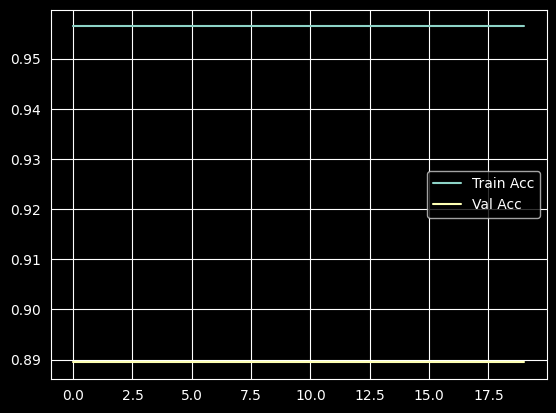

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.86      0.82      1000
           3       0.90      0.91      0.90      1000
           4       0.84      0.81      0.82      1000
           5       0.98      0.94      0.96      1000
           6       0.73      0.68      0.70      1000
           7       0.94      0.95      0.94      1000
           8       0.94      0.98      0.96      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



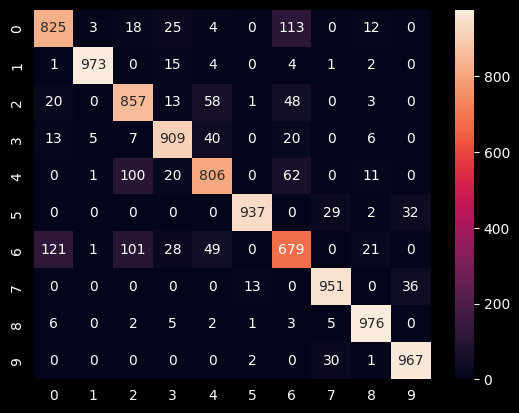

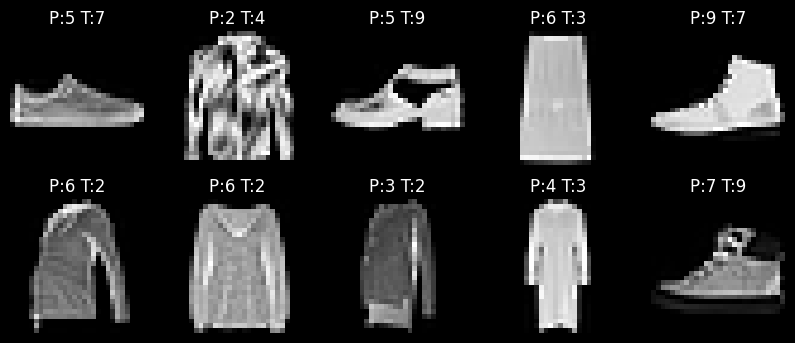

In [13]:
train_losses_d, val_losses_d, train_accs_d, val_accs_d = train_model(
    model_deep,
    train_loader,
    val_loader,
    optimizer,
    criterion
)

plot_curves(train_losses_d, val_losses_d, train_accs_d, val_accs_d)
evaluate(model_deep, test_loader)
show_misclassified(model_deep, test_loader)